# Accessing water point data from the Water Point Dataset Exchange

# Business Problem

Uganda and sub-saharan Africa lack access to basic water services. Not having access to water puts lives at risk through improper sanitation, dehydration. It also reinforce the cycle of poverty and heavily impacts a population that heavily relies on subsistence farming. We want to enable the Ugandan government to repair water point quicker so citizens can have their basic needs and help communities develop and prosper.

# Machine Learning Problem

**Can we predict the functionality of water infrastructure to repair them quicker using Machine Learning?**

# Accessing Water Data
- [Water Point Data Exchange Website](https://www.waterpointdata.org/)
- [API Guide and Dictionary](https://dev.socrata.com/foundry/data.waterpointdata.org/eqje-vguj)
- [Documentation](https://www.waterpointdata.org/docs/WPdx_User_Guide.pdf)

We will be accessing water point data from the source above. This notebook will do some initial cleaning and preparing for further analysis.

In [3]:
# importing relevant packages and functions
%run /Users/thomasadler/Desktop/futuristic-platipus/capstone/notebooks/ta_01_packages_functions.py

/Users/thomasadler/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [4]:
# fetching hidden api key from desktop stored under 'water_api_key'
%run /Users/thomasadler/Desktop/futuristic-platipus/keys.py

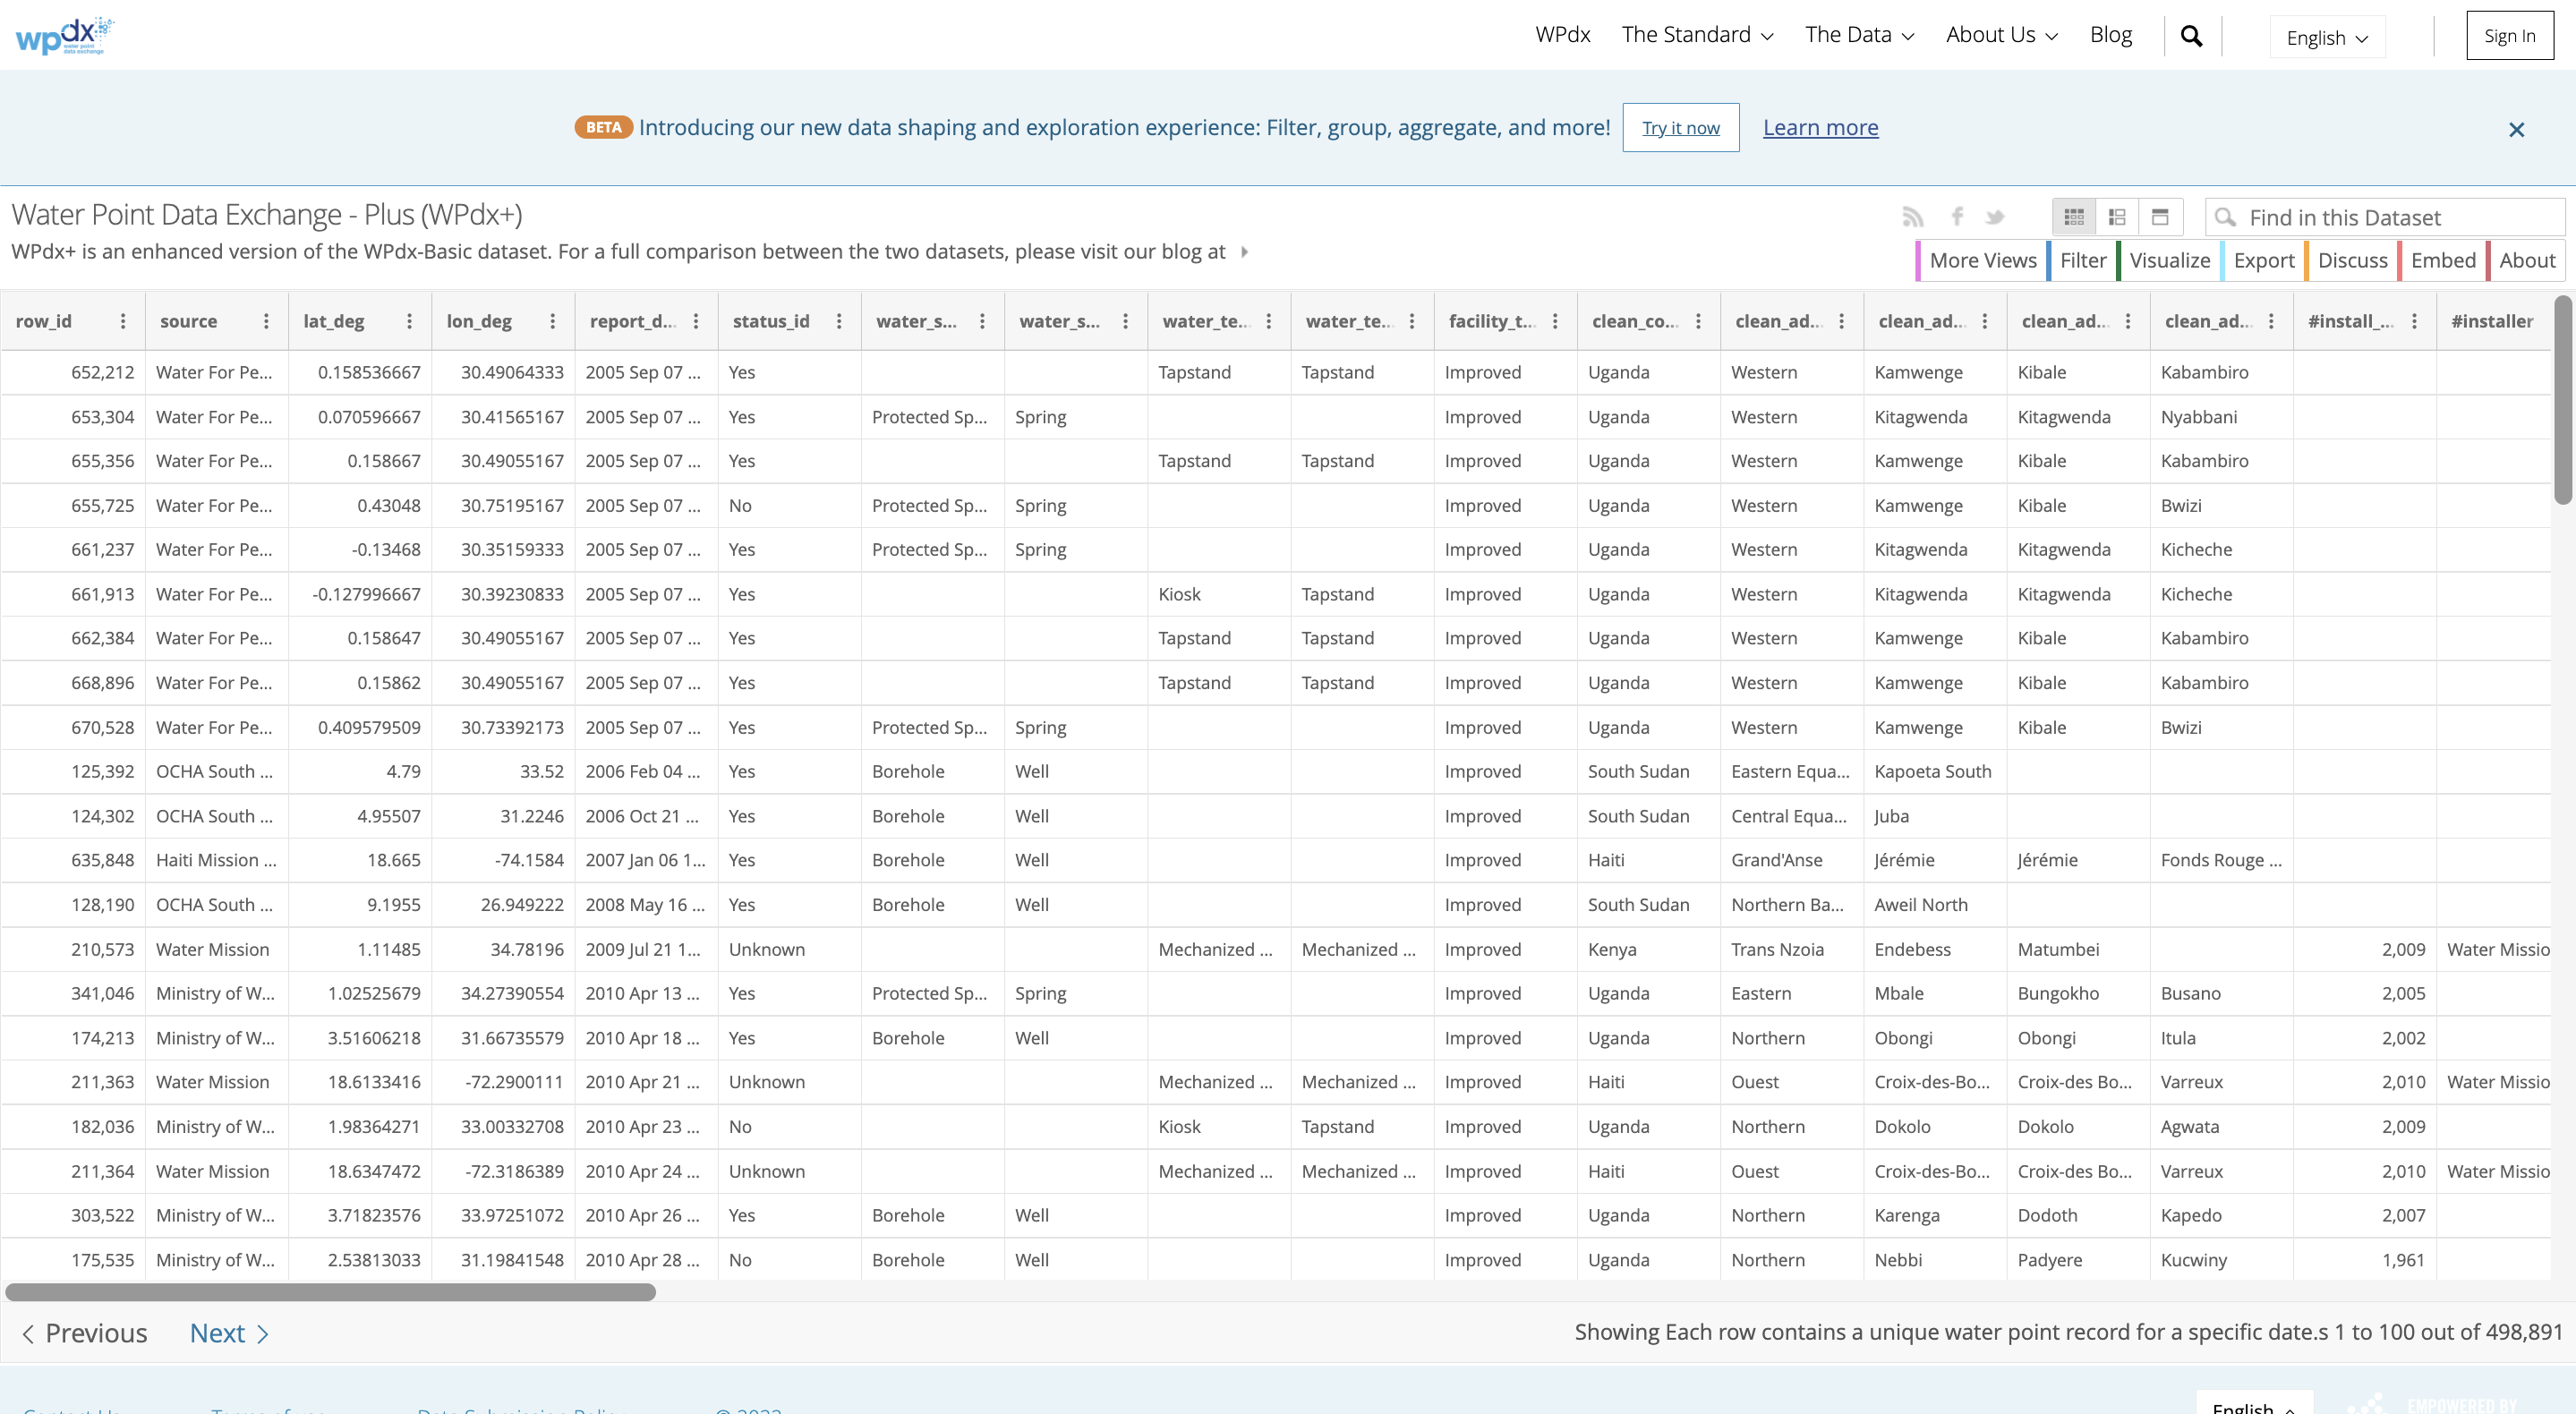

In [5]:
# API we want to access
Image(images_filepath+"wpdx-api.png")

In [6]:
# setting API endpoint, dataset, key and client profile
socrata_domain = 'data.waterpointdata.org'
socrata_dataset_identifier = 'eqje-vguj'
socrata_token = os.environ.get(water_api_key)
client = Socrata(socrata_domain, socrata_token, timeout=10)

The goal is to access every water point recorded in Uganda, all the information associated with that water point and put a very high limit, so we make sure we have accessed all possible points.

In [7]:
# creating query to fetch Uganda water points, all columns included
water_uganda_query = """
select
    *
where
    clean_country_name = 'Uganda'
limit
    200000
"""

In [8]:
# query dataset and store in dataframe
results = client.get(socrata_dataset_identifier, query=water_uganda_query)
water_df = pd.DataFrame.from_records(results)

In [9]:
# keep raw dataset untouched
uganda_water_df = water_df.copy()

In [10]:
# short look at data
uganda_water_df.tail()

,row_id,source,lat_deg,lon_deg,report_date,status_id,water_tech_clean,_water_tech_category,facility_type,clean_country_name,...,subjective_quality,scheme_id,notes,photo_lnk,lat_deg_original,lon_deg_original,fecal_coliform_presence,installer,orig_lnk,fecal_coliform_value
108901,374602,Ugandan Water Project,0.6758382999999955,32.4640283,2022-09-04T00:00:00.000,Yes,Hand Pump - India Mark II,Hand Pump,Improved,Uganda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ugandan Water Project (rehabilitation),NaN,NaN
108902,374581,Ugandan Water Project,0.6553664659999812,32.472553197,2022-11-05T00:00:00.000,Yes,NaN,NaN,Improved,Uganda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ugandan Water Project,NaN,NaN
108903,374572,Ugandan Water Project,0.692485682666941,32.66798296946349,2022-06-30T00:00:00.000,Yes,NaN,NaN,Improved,Uganda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ugandan Water Project,NaN,NaN
108904,374644,Ugandan Water Project,0.18494999999998163,32.3369641,2022-09-06T00:00:00.000,Yes,Hand Pump - India Mark II,Hand Pump,Improved,Uganda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ugandan Water Project (rehabilitation),NaN,NaN
108905,374660,Ugandan Water Project,0.5684852999999981,32.80591690000001,2022-09-05T00:00:00.000,Yes,Hand Pump - India Mark II,Hand Pump,Improved,Uganda,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ugandan Water Project (rehabilitation),NaN,NaN


In [11]:
# looking at column datatypes
uganda_water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108906 entries, 0 to 108905
Data columns (total 67 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   row_id                     108906 non-null  object
 1   source                     108906 non-null  object
 2   lat_deg                    108906 non-null  object
 3   lon_deg                    108906 non-null  object
 4   report_date                108906 non-null  object
 5   status_id                  108906 non-null  object
 6   water_tech_clean           26226 non-null   object
 7   _water_tech_category       26226 non-null   object
 8   facility_type              108906 non-null  object
 9   clean_country_name         108906 non-null  object
 10  clean_adm1                 108906 non-null  object
 11  clean_adm2                 108906 non-null  object
 12  clean_adm3                 108906 non-null  object
 13  clean_adm4                 108906 non-null  

We see that all imported columns are of object type, and that we'll have to fix that next.

We exclude columns which have already been cleaned by the WPD team and stored in another "clean" column. We also exclude columns with links and urls. 

In [12]:
# drop irrelevant columns
uganda_water_df_clean = pd.DataFrame(uganda_water_df.drop(columns=['clean_country_id', 'activity_id', 'adm1', 'adm2', 'adm3', 'country_id',
                                                                   'country_name', 'status', 'water_source', 'management',
                                                                   'water_tech', 'orig_lnk', 'photo_lnk', 'data_lnk',
                                                                   'public_data_source', 'converted', 'created_timestamp',
                                                                   'days_since_report', 'updated']))

# check current columns
uganda_water_df_clean.columns

Index(['row_id', 'source', 'lat_deg', 'lon_deg', 'report_date', 'status_id',
       'water_tech_clean', '_water_tech_category', 'facility_type',
       'clean_country_name', 'clean_adm1', 'clean_adm2', 'clean_adm3',
       'clean_adm4', 'distance_to_primary', 'distance_to_secondary',
       'distance_to_tertiary', 'distance_to_city', 'distance_to_town',
       'usage_cap', 'is_urban', 'staleness_score', 'is_latest', 'location_id',
       'cluster_size', 'new_georeferenced_column_', 'lat_lon_deg', 'count',
       'water_source_clean', 'water_source_category', 'wpdx_id',
       'rehab_priority', 'served_population', 'local_population',
       'crucialness', 'pressure', 'install_year', 'management_clean',
       'status_clean', 'pay', 'subjective_quality', 'scheme_id', 'notes',
       'lat_deg_original', 'lon_deg_original', 'fecal_coliform_presence',
       'installer', 'fecal_coliform_value'],
      dtype='object')

In [13]:
# checking contents of columns we want to convert to binary
print('fecal_coliform_presence distribution:',
      uganda_water_df_clean['fecal_coliform_presence'].value_counts())
print('is_latest distribution:',
      uganda_water_df_clean['is_latest'].value_counts())
print('is_urban distribution:',
      uganda_water_df_clean['is_urban'].value_counts())
print('status_id distribution:',
      uganda_water_df_clean['status_id'].value_counts())

fecal_coliform_presence distribution: Present    1035
Absent      275
Name: fecal_coliform_presence, dtype: int64
is_latest distribution: True     96578
False    12328
Name: is_latest, dtype: int64
is_urban distribution: False    106175
True       2731
Name: is_urban, dtype: int64
status_id distribution: Yes        87600
No         18731
Unknown     2575
Name: status_id, dtype: int64


We want to convert yes/no, True/False columns into 1s and 0s, for modelling's sake. We assume that water points that have an unknown status, are not working.

In [14]:
# convert to binary
uganda_water_df_clean['fecal_coliform_presence'] = uganda_water_df_clean[
    'fecal_coliform_presence'].map({
        'Present': 1,
        'Absent': 0
    })

uganda_water_df_clean['is_latest'] = uganda_water_df_clean['is_latest'].astype(
    'int64')

uganda_water_df_clean['is_urban'] = uganda_water_df_clean['is_urban'].map({
    True:
    1,
    False:
    0
})

uganda_water_df_clean['status_id'] = uganda_water_df_clean['status_id'].map({
    'Yes':
    1,
    'No':
    0,
    'Unknown':
    0
})

# check
uganda_water_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108906 entries, 0 to 108905
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   row_id                     108906 non-null  object 
 1   source                     108906 non-null  object 
 2   lat_deg                    108906 non-null  object 
 3   lon_deg                    108906 non-null  object 
 4   report_date                108906 non-null  object 
 5   status_id                  108906 non-null  int64  
 6   water_tech_clean           26226 non-null   object 
 7   _water_tech_category       26226 non-null   object 
 8   facility_type              108906 non-null  object 
 9   clean_country_name         108906 non-null  object 
 10  clean_adm1                 108906 non-null  object 
 11  clean_adm2                 108906 non-null  object 
 12  clean_adm3                 108906 non-null  object 
 13  clean_adm4                 10

In [15]:
# convert to number
num_columns = ['distance_to_city', 'distance_to_primary', 'lat_deg', 'lat_deg_original',
               'lon_deg', 'lon_deg_original', 'distance_to_secondary', 'distance_to_tertiary',
               'distance_to_town', 'fecal_coliform_value', 'cluster_size', 'count', 'crucialness',
               'install_year', 'local_population', 'pressure',
               'rehab_priority', 'served_population', 'staleness_score', 'usage_cap']

for col in num_columns:
    float_converter(uganda_water_df_clean, col)

# check
uganda_water_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108906 entries, 0 to 108905
Data columns (total 48 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   row_id                     108906 non-null  object 
 1   source                     108906 non-null  object 
 2   lat_deg                    108906 non-null  float32
 3   lon_deg                    108906 non-null  float32
 4   report_date                108906 non-null  object 
 5   status_id                  108906 non-null  int64  
 6   water_tech_clean           26226 non-null   object 
 7   _water_tech_category       26226 non-null   object 
 8   facility_type              108906 non-null  object 
 9   clean_country_name         108906 non-null  object 
 10  clean_adm1                 108906 non-null  object 
 11  clean_adm2                 108906 non-null  object 
 12  clean_adm3                 108906 non-null  object 
 13  clean_adm4                 10

In [16]:
# convert to datetime
date_converter(uganda_water_df_clean, 'report_date')
uganda_water_df_clean['install_year']=pd.to_datetime(uganda_water_df_clean['install_year'], format="%Y")


# check
print(uganda_water_df_clean['report_date'].head())
print(uganda_water_df_clean['install_year'].head())

0   2005-09-07
1   2005-09-07
2   2005-09-07
3   2005-09-07
4   2005-09-07
Name: report_date, dtype: datetime64[ns]
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: install_year, dtype: datetime64[ns]


In [17]:
# select columns with string
str_columns = list(uganda_water_df_clean.select_dtypes("object").columns)

# remove special characters from string columns
for col in str_columns:
    uganda_water_df_clean[col].str.replace('[^\w\s]', '')

In [18]:
# percentage of NA values by columns
uganda_water_df_clean.isna().mean() * 100

row_id                         0.000000
source                         0.000000
lat_deg                        0.000000
lon_deg                        0.000000
report_date                    0.000000
status_id                      0.000000
water_tech_clean              75.918682
_water_tech_category          75.918682
facility_type                  0.000000
clean_country_name             0.000000
clean_adm1                     0.000000
clean_adm2                     0.000000
clean_adm3                     0.000000
clean_adm4                     0.000000
distance_to_primary            0.000000
distance_to_secondary          0.000000
distance_to_tertiary           0.000000
distance_to_city               0.000000
distance_to_town               0.000000
usage_cap                      0.033974
is_urban                     100.000000
staleness_score                0.000000
is_latest                      0.000000
location_id                    0.000000
cluster_size                   0.000000


We decide to drop columns which have more than 50% of its values that are missing. We deem these columns not be of good enough quality to be analysed. Some of these columns pertain to the presence of fecal coliform, the technology of the water point, the price of the water and other notes on the quality of the water available.

In [19]:
# remove columsn where >50% are missing values, using the thresh parameter (0.5)
uganda_water_df_clean = uganda_water_df_clean.dropna(
    axis=1, thresh=0.5 * len(uganda_water_df_clean))

# check
uganda_water_df_clean.isna().mean() * 100

row_id                        0.000000
source                        0.000000
lat_deg                       0.000000
lon_deg                       0.000000
report_date                   0.000000
status_id                     0.000000
facility_type                 0.000000
clean_country_name            0.000000
clean_adm1                    0.000000
clean_adm2                    0.000000
clean_adm3                    0.000000
clean_adm4                    0.000000
distance_to_primary           0.000000
distance_to_secondary         0.000000
distance_to_tertiary          0.000000
distance_to_city              0.000000
distance_to_town              0.000000
usage_cap                     0.033974
staleness_score               0.000000
is_latest                     0.000000
location_id                   0.000000
cluster_size                  0.000000
new_georeferenced_column_     0.000000
lat_lon_deg                   0.000000
count                         0.000000
water_source_clean       

The documentation informs us that this dataset is not supposed to have any duplicate columns or rows.

In [20]:
# checking duplicate rows
# uganda_water_df_clean.duplicated().sum()

In [21]:
# checking duplicate columns
# uganda_water_df_clean.T.duplicated().sum()

We impute the missing values in the remaining columns with the median for their administrative region. We first choose the lowest level, `clean_adm4`, then if there are remaining missing values we choose the second lowest `clean_adm3` and so on. We choose the median so that it is not too sensitive to outliers.

In [22]:
# choose numerical columns
uganda_water_df_clean_numerical = uganda_water_df_clean[
    uganda_water_df_clean.select_dtypes(exclude='object').columns]

# check
uganda_water_df_clean_numerical.head()

,lat_deg,lon_deg,report_date,status_id,distance_to_primary,distance_to_secondary,distance_to_tertiary,distance_to_city,distance_to_town,usage_cap,staleness_score,is_latest,cluster_size,count,served_population,local_population,crucialness,pressure,install_year
0,0.158537,30.490643,2005-09-07,1,37666.023438,4875.484375,23.399448,45104.835938,32223.873047,250.0,14.327719,0,76.0,1.0,NaN,NaN,NaN,NaN,NaT
1,0.070597,30.415651,2005-09-07,1,35843.273438,2602.279297,971.238464,38419.558594,24194.054688,250.0,14.327719,0,8.0,1.0,NaN,NaN,NaN,NaN,NaT
2,0.158667,30.490551,2005-09-07,1,37651.726562,4860.169922,34.916096,45094.210938,32236.693359,250.0,14.327719,0,76.0,1.0,NaN,NaN,NaN,NaN,NaT
3,0.430480,30.751951,2005-09-07,0,14592.108398,16548.333984,1269.275391,58369.609375,23365.746094,250.0,14.327719,1,1.0,1.0,1.0,25.0,0.04,0.004,NaT
4,-0.134680,30.351593,2005-09-07,1,29073.130859,6369.317871,3270.906982,45044.160156,16042.707031,250.0,14.327719,0,2.0,1.0,NaN,NaN,NaN,NaN,NaT


In [23]:
# choose columns with null values
null_cols = uganda_water_df_clean_numerical.isna().sum()
cols_to_impute = null_cols[null_cols > 0].index
cols_to_impute = cols_to_impute.drop('install_year')

# check
cols_to_impute

Index(['usage_cap', 'served_population', 'local_population', 'crucialness',
       'pressure'],
      dtype='object')

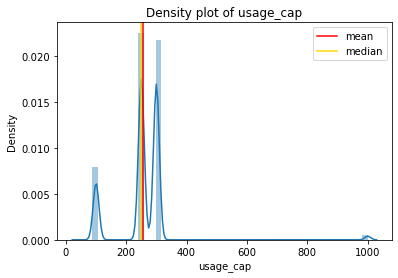

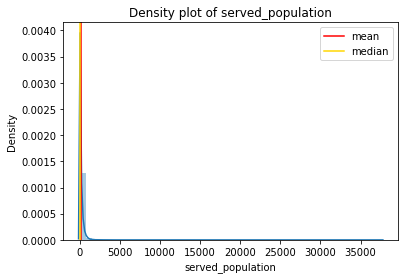

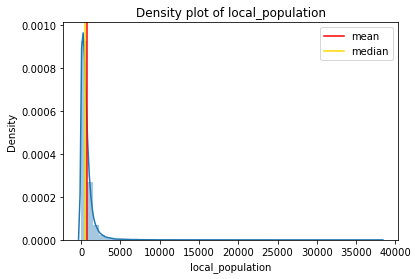

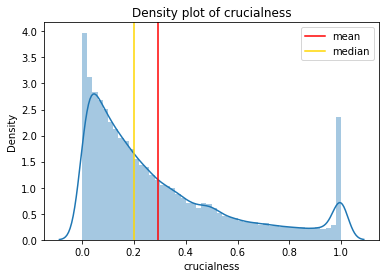

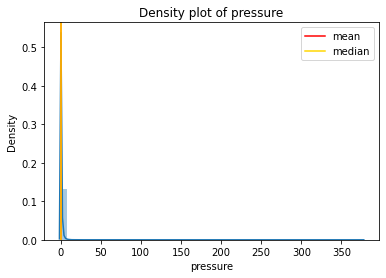

In [24]:
# showing distribution of value we want to inpute and where mean/median is situated
for col in cols_to_impute:
    plt.figure()
    sns.distplot(uganda_water_df_clean[col])
    plt.axvline(uganda_water_df_clean[col].mean(), c='r', label='mean')
    plt.axvline(uganda_water_df_clean[col].median(), c='gold', label='median')
    plt.legend()
    plt.title(f'Density plot of {col}')
    plt.show()

We can confirm that the median is the better choice as it represents our data better.

In [25]:
# fill missing values with adm4 median
for col in cols_to_impute:
    missing_to_regional_median(uganda_water_df_clean, col, 'clean_adm4')

# check
uganda_water_df_clean.isna().sum()

row_id                           0
source                           0
lat_deg                          0
lon_deg                          0
report_date                      0
status_id                        0
facility_type                    0
clean_country_name               0
clean_adm1                       0
clean_adm2                       0
clean_adm3                       0
clean_adm4                       0
distance_to_primary              0
distance_to_secondary            0
distance_to_tertiary             0
distance_to_city                 0
distance_to_town                 0
usage_cap                        0
staleness_score                  0
is_latest                        0
location_id                      0
cluster_size                     0
new_georeferenced_column_        0
lat_lon_deg                      0
count                            0
water_source_clean           17439
water_source_category        17439
wpdx_id                       1092
served_population   

In [26]:
# fill missing values with adm3 median
for col in cols_to_impute:
    missing_to_regional_median(uganda_water_df_clean, col, 'clean_adm3')

# check
uganda_water_df_clean.isna().sum()

row_id                           0
source                           0
lat_deg                          0
lon_deg                          0
report_date                      0
status_id                        0
facility_type                    0
clean_country_name               0
clean_adm1                       0
clean_adm2                       0
clean_adm3                       0
clean_adm4                       0
distance_to_primary              0
distance_to_secondary            0
distance_to_tertiary             0
distance_to_city                 0
distance_to_town                 0
usage_cap                        0
staleness_score                  0
is_latest                        0
location_id                      0
cluster_size                     0
new_georeferenced_column_        0
lat_lon_deg                      0
count                            0
water_source_clean           17439
water_source_category        17439
wpdx_id                       1092
served_population   

In [27]:
# fill missing values with adm2 median
for col in cols_to_impute:
    missing_to_regional_median(uganda_water_df_clean, col, 'clean_adm2')

# check
uganda_water_df_clean.isna().sum()

row_id                           0
source                           0
lat_deg                          0
lon_deg                          0
report_date                      0
status_id                        0
facility_type                    0
clean_country_name               0
clean_adm1                       0
clean_adm2                       0
clean_adm3                       0
clean_adm4                       0
distance_to_primary              0
distance_to_secondary            0
distance_to_tertiary             0
distance_to_city                 0
distance_to_town                 0
usage_cap                        0
staleness_score                  0
is_latest                        0
location_id                      0
cluster_size                     0
new_georeferenced_column_        0
lat_lon_deg                      0
count                            0
water_source_clean           17439
water_source_category        17439
wpdx_id                       1092
served_population   

In [28]:
# fill missing values with adm1 median
for col in cols_to_impute:
    missing_to_regional_median(uganda_water_df_clean, col, 'clean_adm1')

# check
uganda_water_df_clean.isna().sum()

row_id                           0
source                           0
lat_deg                          0
lon_deg                          0
report_date                      0
status_id                        0
facility_type                    0
clean_country_name               0
clean_adm1                       0
clean_adm2                       0
clean_adm3                       0
clean_adm4                       0
distance_to_primary              0
distance_to_secondary            0
distance_to_tertiary             0
distance_to_city                 0
distance_to_town                 0
usage_cap                        0
staleness_score                  0
is_latest                        0
location_id                      0
cluster_size                     0
new_georeferenced_column_        0
lat_lon_deg                      0
count                            0
water_source_clean           17439
water_source_category        17439
wpdx_id                       1092
served_population   

In [29]:
# fill the final null values with the median value of the whole country
for col in cols_to_impute:
    uganda_water_df_clean[col] = uganda_water_df_clean[col].fillna(
        uganda_water_df_clean[col].median())

# check remaining null values
uganda_water_df_clean.isna().sum()

row_id                           0
source                           0
lat_deg                          0
lon_deg                          0
report_date                      0
status_id                        0
facility_type                    0
clean_country_name               0
clean_adm1                       0
clean_adm2                       0
clean_adm3                       0
clean_adm4                       0
distance_to_primary              0
distance_to_secondary            0
distance_to_tertiary             0
distance_to_city                 0
distance_to_town                 0
usage_cap                        0
staleness_score                  0
is_latest                        0
location_id                      0
cluster_size                     0
new_georeferenced_column_        0
lat_lon_deg                      0
count                            0
water_source_clean           17439
water_source_category        17439
wpdx_id                       1092
served_population   

We will not fill the non-numeric columns that still have missing values as the proportion of missing values is too great (15-25%). We will decide what to do with them later in our analysis. We must do this with great care as omitting or filling these columns/rows will have a large impact on the dataset.

In [30]:
# export to cleaned dataset to csv
uganda_water_df_clean.to_csv(data_filepath + 'ta_1_uganda_water_df_clean.csv')

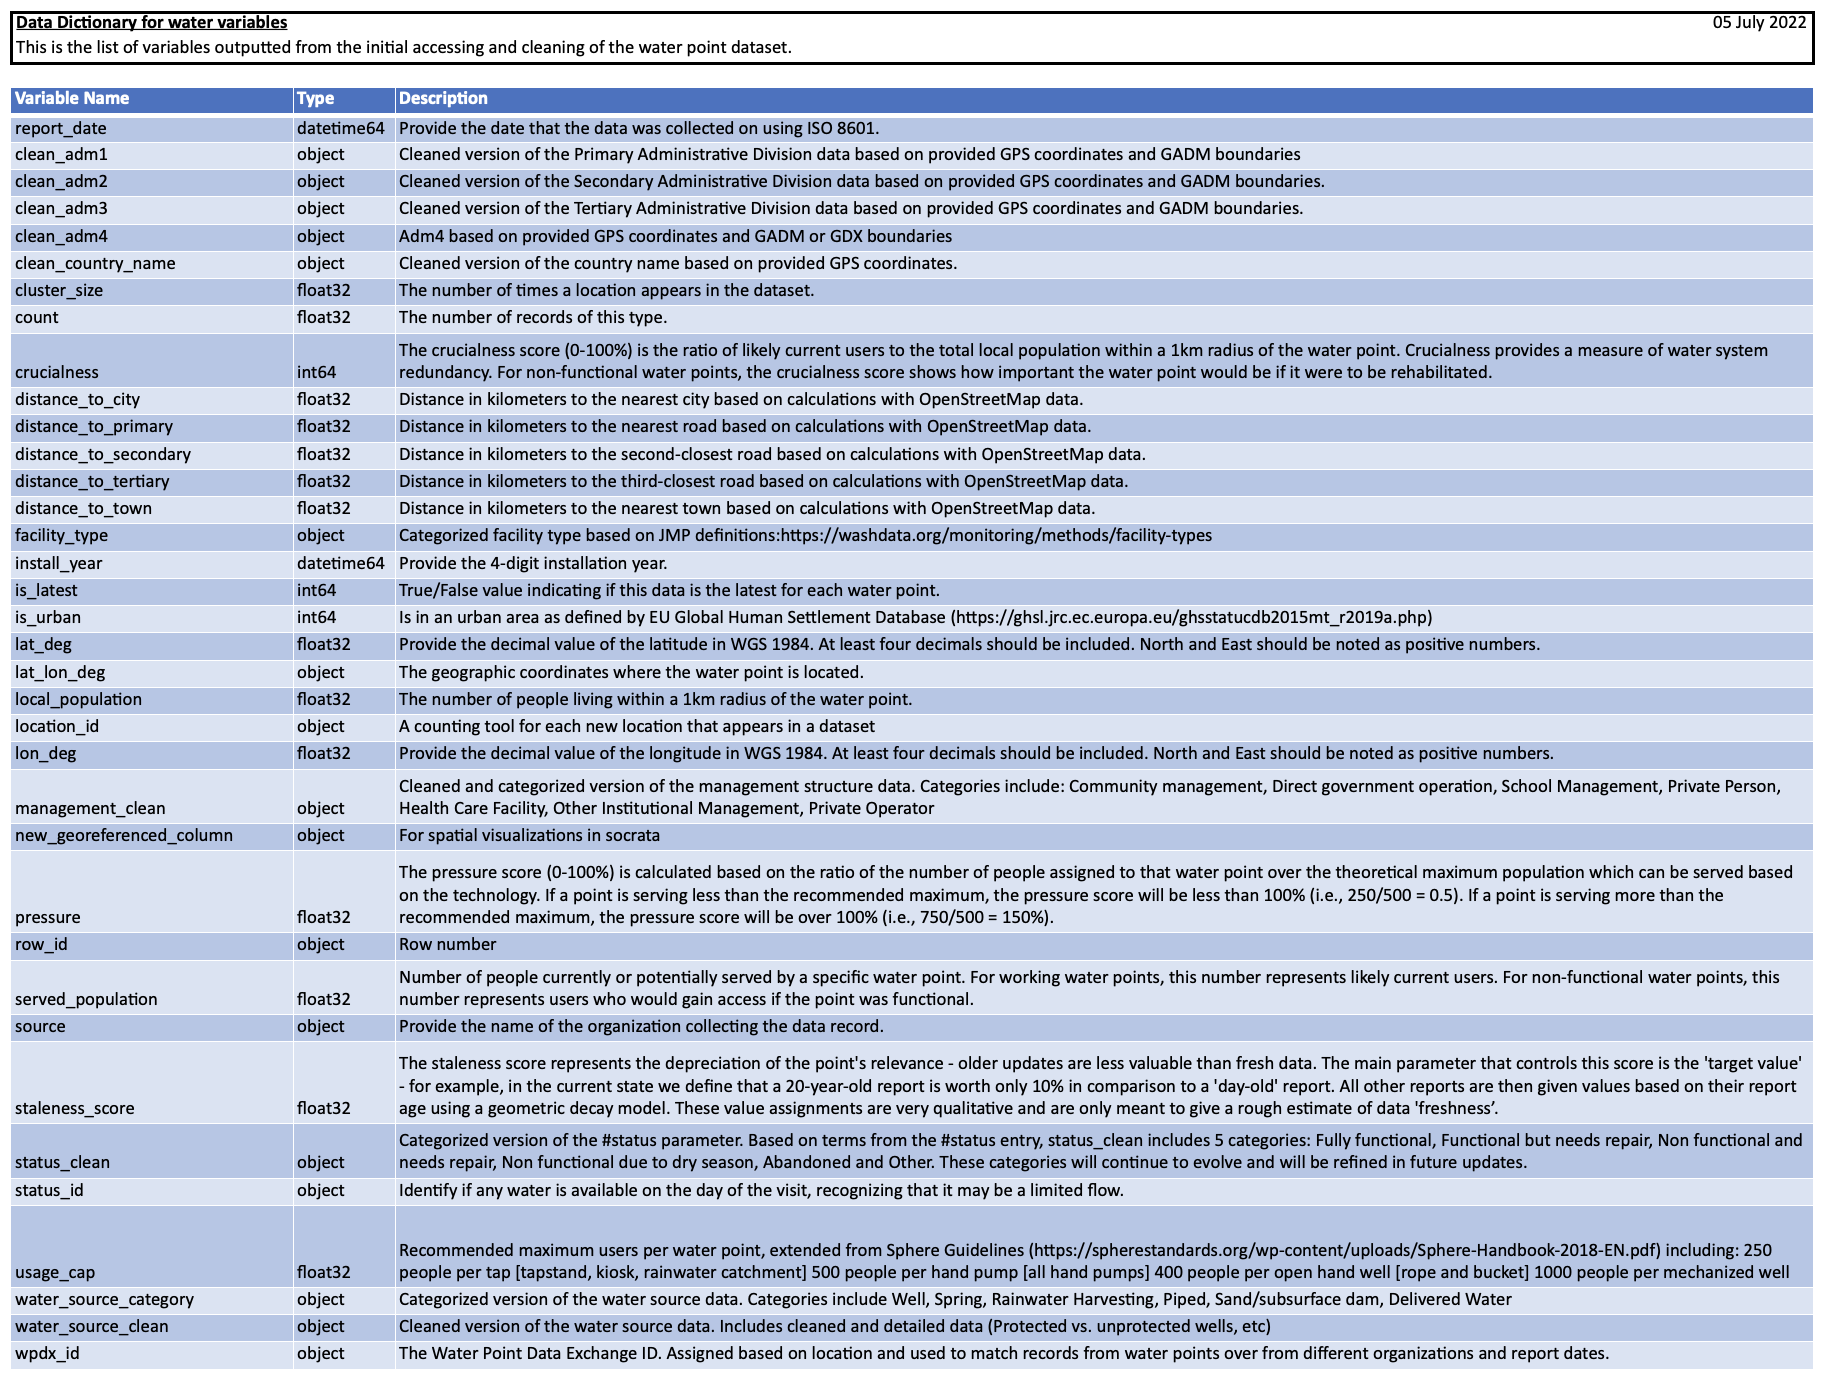

In [31]:
#data dictionary
Image(dictionary_filepath+"1A-Water-Dictionary.png")

In [33]:
# #DEPRECATED-MANUAL WAY TO GET THE MEDIAN FOR EVERY REGION AND FILL NAs

# #constructing columns of interest
# median_columns_adm1=list(cols_to_impute )
# median_columns_adm1.append('clean_adm1')

# #group by adm2, with median
# median_adm1=uganda_water_df_clean[median_columns_adm1].groupby('clean_adm1').median()
# median_adm1.reset_index(inplace=True)

# #merge median dataset with original dataset
# uganda_water_df_clean=pd.merge(uganda_water_df_clean, median_adm1, how='left',\
#                                left_on=uganda_water_df_clean['clean_adm1'],\
#                                right_on=median_adm1['clean_adm1'], suffixes=(None, '_median_adm1'))

# #fill null values with the median value of its region (adm2)
# for col in cols_to_impute:
#     uganda_water_df_clean[col] = uganda_water_df_clean[col].fillna(uganda_water_df_clean\
#                                                                    [f'{col}_median_adm1'])
# #removing key column resulting from the merge
# del uganda_water_df_clean[uganda_water_df_clean.columns[0]]
# uganda_water_df_clean.head()

# #check remaining null values
# uganda_water_df_clean.isna().sum()